In [1]:
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
from sklearn import svm
from sklearn.base import clone
from menelaus.concept_drift import LinearFourRates, ADWINAccuracy, DDM, EDDM, STEPD, MD3

In [2]:
from sklearn.ensemble import RandomForestClassifier

In [4]:
import pandas as pd
import numpy as np

In [5]:
df=pd.read_csv('df2.csv')

In [6]:
df.head()

,Unnamed: 0,category,rating,label,count_punct,Number of Words,exclamation_mark,first_person_noun
0,0,1,5.0,0,5,12,1,1
1,1,1,5.0,0,3,16,0,1
2,2,1,5.0,0,2,14,0,2
3,3,1,1.0,0,2,17,0,1
4,4,1,5.0,0,2,18,0,0


In [7]:
df=df.drop(['Unnamed: 0'], axis=1)

In [8]:
df=df.iloc[:,[0,1,3,4,5,6,2]]

In [9]:
df.head()

,category,rating,count_punct,Number of Words,exclamation_mark,first_person_noun,label
0,1,5.0,5,12,1,1,0
1,1,5.0,3,16,0,1,0
2,1,5.0,2,14,0,2,0
3,1,1.0,2,17,0,1,0
4,1,5.0,2,18,0,0,0


In [10]:
training_size = 30324

In [11]:
X_train = df.loc[0:training_size, ['category','rating','count_punct','Number of Words','exclamation_mark','first_person_noun']]
y_train = df.loc[0:training_size, "label"]
X_test = df.loc[training_size:len(df), ['category','rating','count_punct','Number of Words','exclamation_mark','first_person_noun']]
y_true = df.loc[training_size:len(df), "label"]

In [12]:
np.random.seed(123)
clf = RandomForestClassifier(n_estimators = 100) 
clf.fit(X_train, y_train)
acc_orig = np.cumsum(clf.predict(X_test) == y_true)
acc_orig = acc_orig / np.arange(1, 1 + len(acc_orig))
print(acc_orig)

30324    1.000000
30325    0.500000
30326    0.333333
30327    0.500000
30328    0.600000
           ...   
40427    0.622130
40428    0.622167
40429    0.622205
40430    0.622242
40431    0.622279
Name: label, Length: 10108, dtype: float64


### ADWIN

In [13]:
adwin = ADWINAccuracy()

# Set up DF to record results.
status = pd.DataFrame(
    columns=["index", "y_true", "y_pred", "adwin mean", "drift_detected"]
)
rec_list = []

In [14]:
for i in range(training_size, len(df)):

    X_test = df.loc[[i], ['category','rating','count_punct','Number of Words','exclamation_mark','first_person_noun']]
    y_pred = int(clf.predict(X_test))
    y_true = int(df.loc[[i], "label"])

    adwin.update(y_true, y_pred)
    status.loc[i] = [
        i, y_true, y_pred, adwin.mean(), adwin.drift_state,
    ]

    # If drift is detected, examine the window and retrain.
    if adwin.drift_state == "drift":
        retrain_start = adwin.retraining_recs[0] + training_size
        retrain_end = adwin.retraining_recs[1] + training_size
        rec_list.append([retrain_start, retrain_end])

        # The retraining recommendations produced here correspond to the samples
        # which belong to ADWIN's new, smaller window, after drift is detected.
        # If retraining is not desired, omit the next four lines.
        X_train = df.loc[retrain_start:retrain_end, ['category','rating','count_punct','Number of Words','exclamation_mark','first_person_noun']]
        y_train = df.loc[retrain_start:retrain_end, "label"]
        clf = RandomForestClassifier(n_estimators = 100) 
        clf.fit(X_train, y_train)
status['original_accuracy'] = acc_orig
status['accuracy'] = np.cumsum(status.y_true == status.y_pred)

status['accuracy'] = status['accuracy'] / np.cumsum(np.repeat(1, status.shape[0]))


In [14]:
print(status)

         index  y_true  y_pred  adwin mean drift_detected  original_accuracy  \
30324  30324.0     0.0     0.0    1.000000            NaN           1.000000   
30325  30325.0     0.0     1.0    0.500000            NaN           0.500000   
30326  30326.0     0.0     1.0    0.333333            NaN           0.333333   
30327  30327.0     0.0     0.0    0.500000            NaN           0.500000   
30328  30328.0     0.0     0.0    0.600000            NaN           0.600000   
...        ...     ...     ...         ...            ...                ...   
40427  40427.0     1.0     0.0    0.474882            NaN           0.622130   
40428  40428.0     0.0     0.0    0.475037            NaN           0.622167   
40429  40429.0     1.0     0.0    0.474897            NaN           0.622205   
40430  40430.0     0.0     0.0    0.475052            NaN           0.622242   
40431  40431.0     1.0     0.0    0.474911            NaN           0.622279   

       accuracy  
30324  1.000000  
303

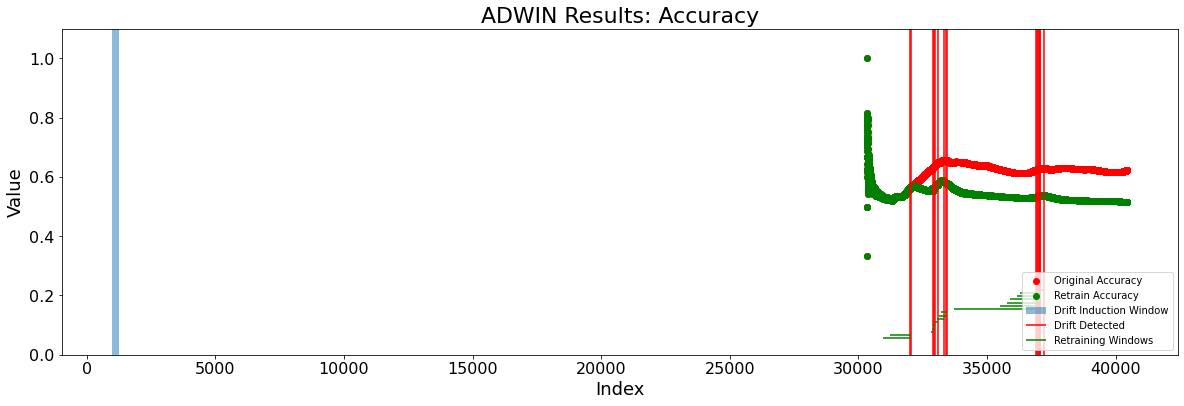

In [41]:
plt.figure(figsize=(20, 6))
plt.scatter("index", "original_accuracy", data=status, label="Original Accuracy", color='red')
plt.scatter("index", "accuracy", data=status, label="Retrain Accuracy", color='green')
plt.grid(False, axis="x")
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title("ADWIN Results: Accuracy", fontsize=22)
plt.ylabel("Value", fontsize=18)
plt.xlabel("Index", fontsize=18)
ylims = [0, 1.1]
plt.ylim(ylims)

plt.axvspan(1000, 1250, alpha=0.5, label="Drift Induction Window")

# Draw red lines that indicate where drift was detected
plt.vlines(
    x=status.loc[status["drift_detected"] == "drift"]["index"],
    ymin=ylims[0],
    ymax=ylims[1],
    label="Drift Detected",
    color="red",
)

# Create a list of lines that indicate the retraining windows.
# Space them evenly, vertically.
rec_list = pd.DataFrame(rec_list)
rec_list["y_val"] = np.linspace(
    start=0.05 * (ylims[1] - ylims[0]) + ylims[0],
    stop=0.2 * ylims[1],
    num=len(rec_list),
)

# Draw green lines that indicate where retraining occurred
plt.hlines(
    y=rec_list["y_val"],
    xmin=rec_list[0],
    xmax=rec_list[1],
    color="green",
    label="Retraining Windows",
)

plt.legend(loc='lower right')
plt.show()
# plt.savefig("example_ADWINAccuracy.png")


In [22]:
X_train = df.loc[0:training_size, ['category','rating','count_punct','Number of Words','exclamation_mark','first_person_noun']]
y_train = df.loc[0:training_size, "label"]
X_test = df.loc[training_size:len(df), ['category','rating','count_punct','Number of Words','exclamation_mark','first_person_noun']]
y_true = df.loc[training_size:len(df), "label"]

In [17]:
np.random.seed(123)
clf = RandomForestClassifier(n_estimators = 100) 
clf.fit(X_train, y_train)
acc_orig = np.cumsum(clf.predict(X_test) == y_true)
acc_orig = acc_orig / np.arange(1, 1 + len(acc_orig))
print(acc_orig)

30324    1.000000
30325    0.500000
30326    0.333333
30327    0.500000
30328    0.600000
           ...   
40427    0.622130
40428    0.622167
40429    0.622205
40430    0.622242
40431    0.622279
Name: label, Length: 10108, dtype: float64


### DDM

In [18]:
ddm = DDM(n_threshold=100, warning_scale=7, drift_scale=10)

# setup DF to store results
status = pd.DataFrame(columns=["index", "y_true", "y_pred", "drift_detected"])
rec_list = []


In [19]:
for i in range(training_size, len(df)):

    X_test = df.loc[[i], ['category','rating','count_punct','Number of Words','exclamation_mark','first_person_noun']]
    y_pred = int(clf.predict(X_test))
    y_true = int(df.loc[[i], "label"])

    ddm.update(y_true, y_pred)
    status.loc[i] = [i, y_true, y_pred, ddm.drift_state]

    # If drift is detected, examine the window and retrain.
    if ddm.drift_state == "drift":
        print("Detected at"+str(i))
        retrain_start = ddm.retraining_recs[0] +training_size
        retrain_end = ddm.retraining_recs[1] + training_size
        if (
            retrain_start == retrain_end
        ):  # minimum retraining window in case of sudden drift
            retrain_start = max(0, retrain_start - 300)
        rec_list.append([retrain_start, retrain_end])

        # If retraining is not desired, omit the next four lines.
        X_train = df.loc[retrain_start:retrain_end, ['category','rating','count_punct','Number of Words','exclamation_mark','first_person_noun']]
        y_train = df.loc[retrain_start:retrain_end, "label"]
        clf = RandomForestClassifier(n_estimators = 100) 
        clf.fit(X_train, y_train)

status['original_accuracy'] = acc_orig
status['accuracy'] = np.cumsum(status.y_true == status.y_pred)

status['accuracy'] = status['accuracy'] / np.cumsum(np.repeat(1, status.shape[0]))

Detected at31558


In [20]:
print(status)

         index  y_true  y_pred drift_detected  original_accuracy  accuracy
30324  30324.0     0.0     0.0            NaN           1.000000  1.000000
30325  30325.0     0.0     1.0            NaN           0.500000  0.500000
30326  30326.0     0.0     1.0            NaN           0.333333  0.333333
30327  30327.0     0.0     0.0            NaN           0.500000  0.500000
30328  30328.0     0.0     0.0            NaN           0.600000  0.600000
...        ...     ...     ...            ...                ...       ...
40427  40427.0     1.0     1.0            NaN           0.622130  0.529592
40428  40428.0     0.0     1.0            NaN           0.622167  0.529540
40429  40429.0     1.0     1.0            NaN           0.622205  0.529586
40430  40430.0     0.0     1.0            NaN           0.622242  0.529534
40431  40431.0     1.0     1.0            NaN           0.622279  0.529581

[10108 rows x 6 columns]


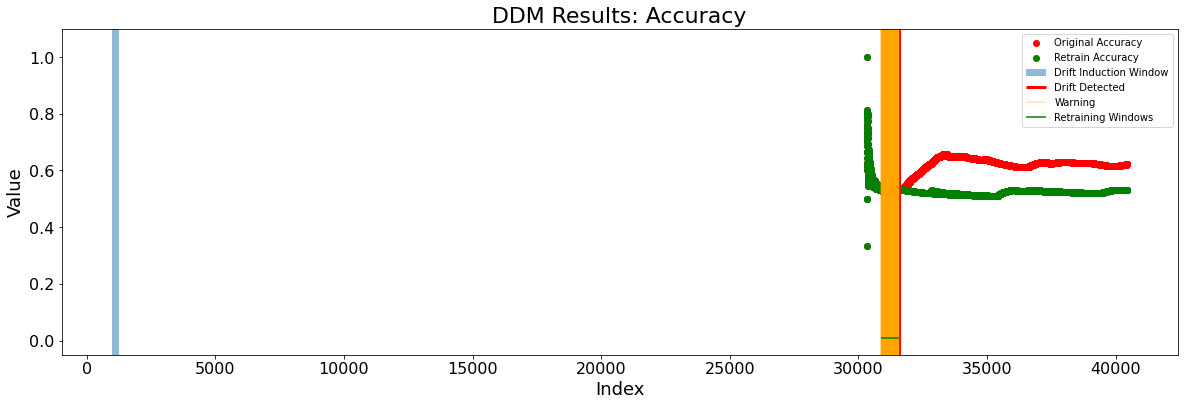

In [47]:
plt.figure(figsize=(20, 6))
plt.scatter("index", "original_accuracy", data=status, label="Original Accuracy", color='red')
plt.scatter("index", "accuracy", data=status, label="Retrain Accuracy", color='green')
plt.grid(False, axis="x")
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title("DDM Results: Accuracy", fontsize=22)
plt.ylabel("Value", fontsize=18)
plt.xlabel("Index", fontsize=18)
ylims = [-0.05, 1.1]
plt.ylim(ylims)

plt.axvspan(1000, 1250, alpha=0.5, label="Drift Induction Window")

# Draw red lines that indicate where drift was detected
plt.vlines(
    x=status.loc[status["drift_detected"] == "drift"]["index"],
    ymin=ylims[0],
    ymax=ylims[1],
    label="Drift Detected",
    color="red",
    linewidth=3,
)

# Draw orange lines that indicate where warnings of drift were provided
plt.vlines(
    x=status.loc[status["drift_detected"] == "warning"]["index"],
    ymin=ylims[0],
    ymax=ylims[1],
    label="Warning",
    color="orange",
    alpha=0.3,
)

# Create a list of lines that indicate the retraining windows.
# Space them evenly, vertically.
rec_list = pd.DataFrame(rec_list)
rec_list["y_val"] = np.linspace(
    start=0.05 * (ylims[1] - ylims[0]) + ylims[0],
    stop=0.2 * ylims[1],
    num=len(rec_list),
)

# Draw green lines that indicate where retraining occurred
plt.hlines(
    y=rec_list["y_val"],
    xmin=rec_list[0],
    xmax=rec_list[1],
    color="green",
    label="Retraining Windows",
)

plt.legend()
plt.show()
# plt.savefig("example_DDM.png")

### EDDM

In [23]:
np.random.seed(123)
clf = RandomForestClassifier(n_estimators = 100) 
clf.fit(X_train, y_train)
acc_orig = np.cumsum(clf.predict(X_test) == y_true)
acc_orig = acc_orig / np.arange(1, 1 + len(acc_orig))
print(acc_orig)

30324    1.000000
30325    0.500000
30326    0.333333
30327    0.500000
30328    0.600000
           ...   
40427    0.622130
40428    0.622167
40429    0.622205
40430    0.622242
40431    0.622279
Name: label, Length: 10108, dtype: float64


In [24]:
eddm = EDDM(n_threshold=30, warning_thresh=0.7, drift_thresh=0.5)

# setup DF to store results
status = pd.DataFrame(columns=["index", "y_true", "y_pred", "drift_detected"])
rec_list = []

In [25]:
for i in range(training_size, len(df)):

    X_test = df.loc[[i], ['category','rating','count_punct','Number of Words','exclamation_mark','first_person_noun']]
    y_pred = int(clf.predict(X_test))
    y_true = int(df.loc[[i], "label"])

    eddm.update(y_true, y_pred)
    status.loc[i] = [i, y_true, y_pred, eddm.drift_state]

    # If drift is detected, examine the window and retrain.
    if eddm.drift_state == "drift":
        retrain_start = eddm.retraining_recs[0] + training_size
        retrain_end = eddm.retraining_recs[1] + training_size
        if (
            retrain_start == retrain_end
        ):  # minimum retraining window in case of sudden drift
            retrain_start = max(0, retrain_start - 300)
        rec_list.append([retrain_start, retrain_end])

        # If retraining is not desired, omit the next four lines.
        X_train = df.loc[retrain_start:retrain_end, ['category','rating','count_punct','Number of Words','exclamation_mark','first_person_noun']]
        y_train = df.loc[retrain_start:retrain_end, "label"]
        clf = RandomForestClassifier(n_estimators = 100) 
        clf.fit(X_train, y_train)

status['original_accuracy'] = acc_orig
status['accuracy'] = np.cumsum(status.y_true == status.y_pred)

status['accuracy'] = status['accuracy'] / np.cumsum(np.repeat(1, status.shape[0]))

In [28]:
print(status)

         index  y_true  y_pred drift_detected  original_accuracy  accuracy
30324  30324.0     0.0     0.0            NaN           1.000000  1.000000
30325  30325.0     0.0     1.0            NaN           0.500000  0.500000
30326  30326.0     0.0     1.0            NaN           0.333333  0.333333
30327  30327.0     0.0     0.0            NaN           0.500000  0.500000
30328  30328.0     0.0     0.0            NaN           0.600000  0.600000
...        ...     ...     ...            ...                ...       ...
40427  40427.0     1.0     1.0            NaN           0.622130  0.588480
40428  40428.0     0.0     1.0            NaN           0.622167  0.588422
40429  40429.0     1.0     1.0            NaN           0.622205  0.588462
40430  40430.0     0.0     1.0            NaN           0.622242  0.588404
40431  40431.0     1.0     1.0            NaN           0.622279  0.588445

[10108 rows x 6 columns]


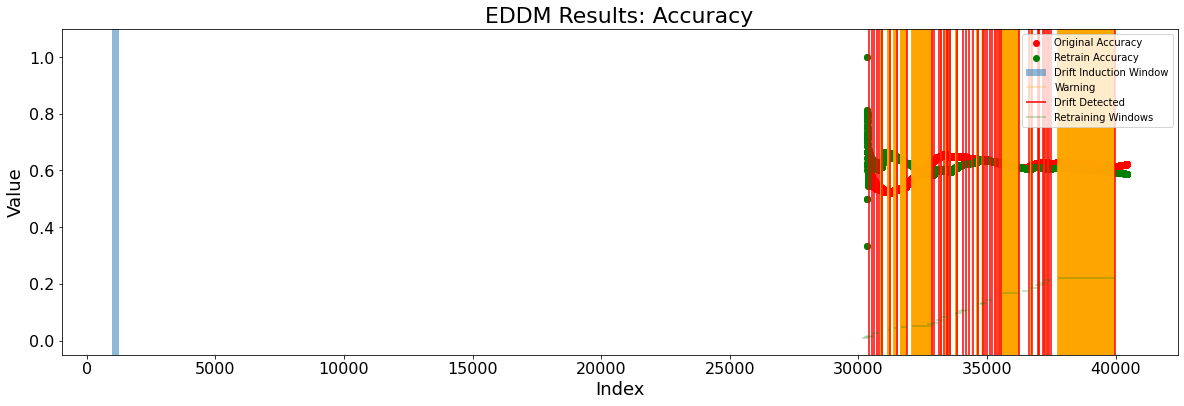

In [54]:
plt.figure(figsize=(20, 6))
plt.scatter("index", "original_accuracy", data=status, label="Original Accuracy", color='red')
plt.scatter("index", "accuracy", data=status, label="Retrain Accuracy", color='green')
plt.grid(False, axis="x")
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title("EDDM Results: Accuracy", fontsize=22)
plt.ylabel("Value", fontsize=18)
plt.xlabel("Index", fontsize=18)
ylims = [-0.05, 1.1]
plt.ylim(ylims)

plt.axvspan(1000, 1250, alpha=0.5, label="Drift Induction Window")

# Draw orange lines that indicate where warnings of drift were provided
plt.vlines(
    x=status.loc[status["drift_detected"] == "warning"]["index"],
    ymin=ylims[0],
    ymax=ylims[1],
    label="Warning",
    color="orange",
    alpha=0.3,
)

# Draw red lines that indicate where drift was detected
plt.vlines(
    x=status.loc[status["drift_detected"] == "drift"]["index"],
    ymin=ylims[0],
    ymax=ylims[1],
    label="Drift Detected",
    color="red",
)
# Create a list of lines that indicate the retraining windows.
# Space them evenly, vertically.
rec_list = pd.DataFrame(rec_list)
rec_list["y_val"] = np.linspace(
    start=0.05 * (ylims[1] - ylims[0]) + ylims[0],
    stop=0.2 * ylims[1],
    num=len(rec_list),
)

# Draw green lines that indicate where retraining occurred
plt.hlines(
    y=rec_list["y_val"],
    xmin=rec_list[0],
    xmax=rec_list[1],
    color="green",
    label="Retraining Windows",
    alpha=0.3,
)

plt.legend()
plt.show()
# plt.savefig("example_EDDM.png")